In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import datetime 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
#以下为解决中文无法显示的问题
#针对matplotlib
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~设置起、止日期~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

enddate = datetime.date.today()

startdate = enddate + datetime.timedelta(days=-7)       #“-7”代表往前7天

start_date = startdate.strftime('%Y/%m/%d')    #加不加“%H:%M:%S”无所谓

end_date = enddate.strftime('%Y/%m/%d')

print(start_date,type(start_date),end_date,type(end_date))

2023/03/19 <class 'str'> 2023/03/26 <class 'str'>


In [4]:
#【注意】——这里取数范围为【All Bonds】

all_bond_data = w.wset("newbondissueview",
       "startdate="+start_date+";enddate="+end_date+";datetype=startdate;bondtype=all;dealmarket=allmarkets;maingrade=all",
      usedf=True)
all_bond_data = all_bond_data[1]
all_bond_data.tail(7)

,windcode,bondshortname
1174,012381105.IB,23上海华谊SCP002
1175,012381104.IB,23中化国际SCP002
1176,012381103.IB,23中林集团SCP003
1177,012381102.IB,23中交建SCP004
1178,012381101.IB,23娄城高新SCP003
1179,012381093.IB,23易鑫租赁SCP001
1180,012300245.IB,23悦达SCP003


In [5]:
all_bond_data["Wind债券一级分类"]=w.wss(list(all_bond_data["windcode"].values), "windl1type",usedf=True)[1].values
all_bond_data["Wind债券二级分类"]=w.wss(list(all_bond_data["windcode"].values), "windl2type",usedf=True)[1].values
all_bond_data
# all_bond_data.to_excel("本周发行所有债券.xlsx")

,windcode,bondshortname,Wind债券一级分类,Wind债券二级分类
1,zc23032201.IB,23晋建5号ABN001优先,资产支持证券,交易商协会ABN
2,zc23031705.SZ,悦融3次,资产支持证券,证监会主管ABS
3,zc23031704.SZ,悦融3优,资产支持证券,证监会主管ABS
4,zc23031702.IB,23鸿富1C,资产支持证券,银保监会主管ABS
5,zc23031701.IB,23鸿富1优先,资产支持证券,银保监会主管ABS
...,...,...,...,...
1176,012381103.IB,23中林集团SCP003,短期融资券,超短期融资债券
1177,012381102.IB,23中交建SCP004,短期融资券,超短期融资债券
1178,012381101.IB,23娄城高新SCP003,短期融资券,超短期融资债券
1179,012381093.IB,23易鑫租赁SCP001,短期融资券,超短期融资债券


In [6]:
# all_bond_data.to_excel("本周发行所有债券.xlsx")

## 以上为【全部Bond】，现仅筛选利率债：【国债】+【政金债】+【地方政府债】

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~由于all_bond_data是【全部bond】，使用以下2种方法筛选出【利率债】~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# 如果你要筛选的类别比较多，可以把它们放在一个列表中，然后使用 isin 方法来进行筛选——chatgpt
categories_policy = ["国债","政策银行债","地方政府债"]

#【方法一】——使用df[df['Wind债券二级分类'].isin(categories_policy)]

#【方法二】——使用df.query
policy_bond_data = all_bond_data.query('`Wind债券二级分类`.isin(@categories_policy)') 

#~~~~~~~~~~~~由于使用df.query筛选后index不会自动调整。所以要重新设置index~~~~~~~~~~~~~~~~
policy_bond_data = policy_bond_data.reset_index(drop=True)#——reset_index 方法默认保留原索引，可以通过设置drop=True删除原索引

policy_bond_data.index = policy_bond_data.index + 1 #index不设置默认从“0”开始

policy_bond_data.tail(5)
# policy_bond_data.to_excel("本周发行利率债（简要信息）.xlsx")

,windcode,bondshortname,Wind债券一级分类,Wind债券二级分类
114,101966.IB,23青岛13,地方政府债,地方政府债
115,101965.IB,23青岛12,地方政府债,地方政府债
116,092318002.IB,23农发清发02,金融债,政策银行债
117,092318001Z01.IB,23农发清发01(增发1),金融债,政策银行债
118,092302001Z09.IB,23国开清发01(增发9),金融债,政策银行债


In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~添加【其他信息】~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

policy_bond_data["发行量（亿）"] = w.wss(list(policy_bond_data["windcode"].values), "issueamount", usedf=True)[1].values
policy_bond_data["发行量（亿）"] = policy_bond_data["发行量（亿）"]/100000000

policy_bond_data["票面利率"] = w.wss(list(policy_bond_data["windcode"].values), "couponrate", usedf=True)[1].values
policy_bond_data["发行人"] = w.wss(list(policy_bond_data["windcode"].values), "issuershortened", usedf=True)[1].values
# policy_bond_data["发行人企业性质"] = w.wss(list(policy_bond_data["windcode"].values), "abs_industry1", usedf=True)[1].values

policy_bond_data["发行期限（年，未调整）"] = w.wss(list(policy_bond_data["windcode"].values), "term", usedf=True)[1].values
policy_bond_data["发行期限（年，未调整）"] = policy_bond_data["发行期限（年，未调整）"].round(2)
#上一行round（2）会导致显示为“10.0”，不好看，这里把“.0”去掉
policy_bond_data["发行期限（年，未调整）"] = policy_bond_data["发行期限（年，未调整）"].astype(int)
#将期限小于等于1年的合并，为了后面画图好看
policy_bond_data["发行期限（年）"] = np.where(policy_bond_data["发行期限（年，未调整）"]<=1,"1及以下（含）",
                                          policy_bond_data["发行期限（年，未调整）"])



# 【Nan值】——为【周五】发行成功，但【缴款日为下周一】的债券，所以发行量会有Nan值

policy_bond_data.tail(5).fillna('-') #这里依然保留Nan值

,windcode,bondshortname,Wind债券一级分类,Wind债券二级分类,发行量（亿）,票面利率,发行人,发行期限（年，未调整）,发行期限（年）
114,101966.IB,23青岛13,地方政府债,地方政府债,4.15,2.93,青岛市人民政府,7,7
115,101965.IB,23青岛12,地方政府债,地方政府债,17.18,2.93,青岛市人民政府,7,7
116,092318002.IB,23农发清发02,金融债,政策银行债,70.00,2.58,农业发展银行,2,2
117,092318001Z01.IB,23农发清发01(增发1),金融债,政策银行债,50.00,3.01,农业发展银行,7,7
118,092302001Z09.IB,23国开清发01(增发9),金融债,政策银行债,15.00,2.87,国家开发银行,7,7


In [9]:
# policy_bond_data.to_excel("本周发行利率债（全部信息）.xlsx")

<br/>

<center> <font face="songti",font size="6">【一级发行情况】

<br/>

## 数据透视表——发行量（DataFrame展示用）

In [10]:
# #【自定义排序】——chatgpt

# order = ["国家开发银行", "进出口银行", "农业发展银行"]
# policy_bond_data["发行人"] = pd.Categorical(policy_bond_data["发行人"], categories=order, ordered=True)
# policy_bond_data = policy_bond_data.sort_values(by="发行人")

# # policy_bond_data

In [11]:
# 数据透视——发行量

                            #可以多维，如：index=['term','Mainrating']
policy_bond_data_IA = policy_bond_data.pivot_table(index=['Wind债券二级分类'],columns=['发行期限（年）'],#fill_value="-",
                            aggfunc='sum',values='发行量（亿）',margins=True, margins_name='Total' #margins=True才显示最边上的加总额
                           )
# 调整小数点
policy_bond_data_IA = policy_bond_data_IA.round(2)

# 重新排序
policy_bond_data_IA_reindex_list = ['1及以下（含）','2','3','5','7','10','15','20','30','Total']
policy_bond_data_IA = policy_bond_data_IA.reindex(columns = policy_bond_data_IA_reindex_list)

policy_bond_data_IA.fillna("-") 
# policy_bond_data_IA.to_excel("本周信政金债数据透视表.xlsx")

发行期限（年）,1及以下（含）,2,3,5,7,10,15,20,30,Total
Wind债券二级分类,,,,,,,,,,
国债,1280.0,-,-,890.00,880.00,-,-,-,-,3280.00
地方政府债,4.5,-,423.46,93.06,438.08,766.2,508.03,736.43,410.62,3380.37
政策银行债,270.0,126.0,230.0,274.40,65.00,520.0,-,20.0,-,1505.40
Total,1554.5,126.0,653.46,1257.46,1383.08,1286.2,508.03,756.43,410.62,8165.77


In [12]:
# policy_bond_data_IA.to_excel("本周信政金债数据透视表（发行量）.xlsx")

## 热力图——发行量

In [13]:
# 去掉margin行和列
policy_bond_data_IA_forplot = policy_bond_data_IA.iloc[0:len(policy_bond_data_IA)-1,0:len(policy_bond_data_IA.T)-1]

policy_bond_data_IA_forplot

发行期限（年）,1及以下（含）,2,3,5,7,10,15,20,30
Wind债券二级分类,,,,,,,,,
国债,1280.0,NaN,NaN,890.00,880.00,NaN,NaN,NaN,NaN
地方政府债,4.5,NaN,423.46,93.06,438.08,766.2,508.03,736.43,410.62
政策银行债,270.0,126.0,230.00,274.40,65.00,520.0,NaN,20.00,NaN


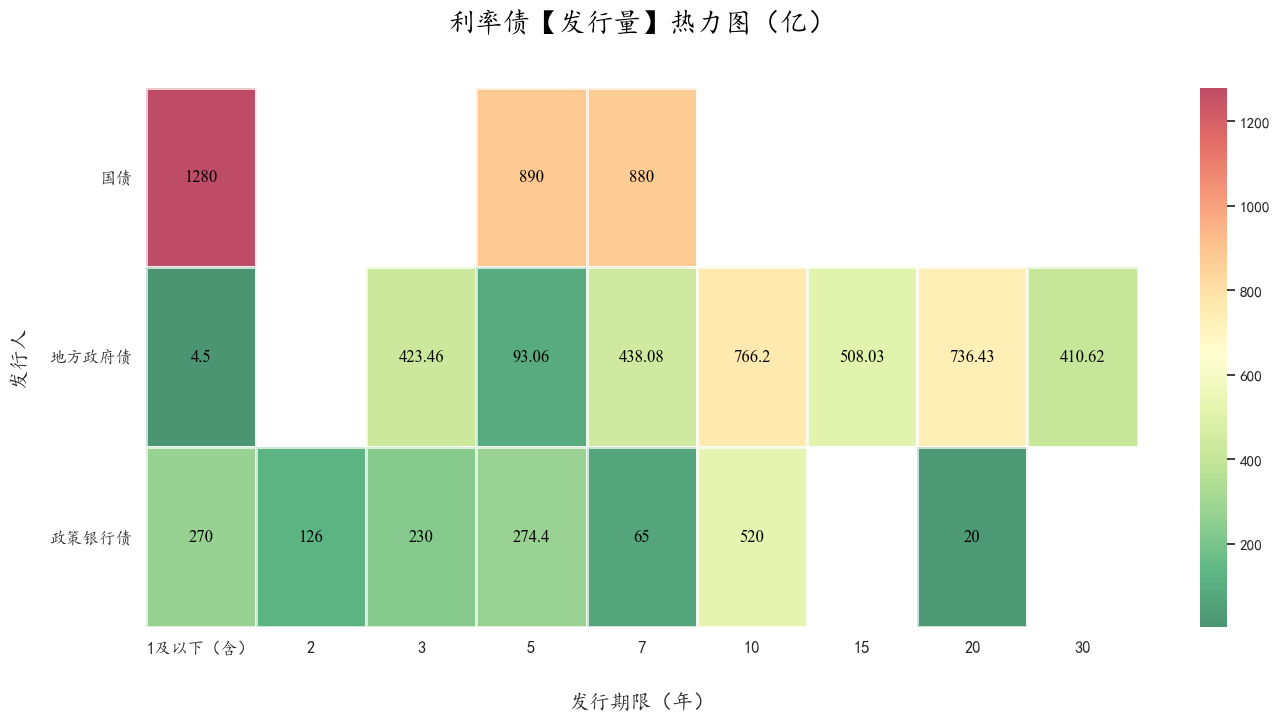

In [14]:
sns.set(font='KaiTi',style='white') #此行为正常显示中文：这里选择为楷体

plt.figure(figsize=(16,7))
# sns.set_context({"figure.figsize":(16,7)})
# sns.set_style('white') #有darkgrid（灰色背景+白网格）、whitegrid（白色背景+黑网格）、dark（仅灰色背景）、white（仅白色背景）
#                       #、ticks（坐标轴带刻度）5种预设的主题

sns.heatmap(policy_bond_data_IA_forplot, annot=True, fmt='g',annot_kws={"family":"Times New Roman","size": 12,'color':'black'},
            cmap="RdYlGn_r", cbar=True,cbar_kws={'orientation': 'vertical'},mask=False,linewidth=.8,linecolor='white',alpha=0.7,
            square=False)
#【好看的cmp】：后面加"_r"即代表色带相反——Greens Oranges OrRd summer summer_r vlag Wistia Blues RdBu_r Reds RdYlGn_r GnBu pink_r

# annot: 默认为False，为True的话，会在格子上显示数字
# annot_kws={"family":"Times New Roman","size": 12,'color':'black'} 修改方格内字体大小、颜色等
# mask可以设置条件判断，如：mask=(CD_IR<=0)
# square : 为‘True’时，整个网格为一个正方形
# cbar=True——显示右方颜色条

plt.title('利率债【发行量】热力图（亿）', fontsize = 20,color='black',fontweight='bold',
          bbox=dict(ec='w',fc ='white'), #facecolor(简写fc)背景颜色, edgecolor(简写ec)边框线条颜色                                                   
          fontstyle='normal',family='KaiTi',pad =40  # pad为调整标题与图片的距离
         )
plt.xlabel('发行期限（年）',family='KaiTi', fontsize = 15, fontweight='bold', labelpad=25) 
plt.ylabel('发行人',family='KaiTi',fontweight='bold',fontsize = 15, labelpad=15, rotation=90)

# #调整y轴【刻度】显示
plt.xticks(fontsize=12,fontproperties= 'KaiTi', rotation=0)
plt.yticks(fontsize=13,fontproperties = 'KaiTi',horizontalalignment='right',rotation=0)

#horizontalalignment='left',multialignment='left',
# horizontalalignment，控制文本的 x 位置参数，对齐左侧、中心或右侧:'center', 'right', 'left'
# verticalalignment 控制文本的 y 位置参数，对齐底部、中心或顶部:'top', 'bottom', 'center', 'baseline', 'center_baseline'
# multialignment，仅用于换行符分隔的字符串，控制不同的行是左对齐、居中还是右对齐。

plt.show()

## 数据透视表——发行利率（DataFrame展示用）

In [15]:
# 数据透视——发行利率

                            #可以多维，如：index=['term','Mainrating']
policy_bond_data_IR = policy_bond_data.pivot_table(index=['Wind债券二级分类'],columns=['发行期限（年）'],aggfunc='mean',#fill_value="-",
                            values='票面利率',margins=True, margins_name='Total' #margins=True才显示最边上的加总额
                           )
#调整小数点
policy_bond_data_IR = policy_bond_data_IR.round(2)

# 重新排序
policy_bond_data_IR_reindex_list = ['1及以下（含）','2','3','5','7','10','15','20','30','Total']
policy_bond_data_IR = policy_bond_data_IR.reindex(columns = policy_bond_data_IR_reindex_list)

policy_bond_data_IR.fillna('-')  #这里依然保留Nan值
# policy_bond_data_IR.to_excel("本周信政金债（发行利率数据透视）.xlsx")

发行期限（年）,1及以下（含）,2,3,5,7,10,15,20,30,Total
Wind债券二级分类,,,,,,,,,,
国债,1.92,-,-,2.64,2.80,-,-,-,-,2.51
地方政府债,2.35,-,2.64,2.78,2.94,2.97,3.11,3.24,3.34,3.05
政策银行债,2.25,2.51,2.68,2.83,2.94,3.1,-,3.49,-,2.72
Total,2.18,2.51,2.66,2.78,2.93,2.99,3.11,3.25,3.34,2.97


In [16]:
# policy_bond_data_IR.to_excel("本周信政金债（发行利率数据透视）.xlsx")

## 热力图——发行利率

In [17]:
# 去掉margin行和列
policy_bond_data_IR_forplot = policy_bond_data_IR.iloc[0:len(policy_bond_data_IA)-1,0:len(policy_bond_data_IA.T)-1]

policy_bond_data_IR_forplot

发行期限（年）,1及以下（含）,2,3,5,7,10,15,20,30
Wind债券二级分类,,,,,,,,,
国债,1.92,NaN,NaN,2.64,2.80,NaN,NaN,NaN,NaN
地方政府债,2.35,NaN,2.64,2.78,2.94,2.97,3.11,3.24,3.34
政策银行债,2.25,2.51,2.68,2.83,2.94,3.10,NaN,3.49,NaN


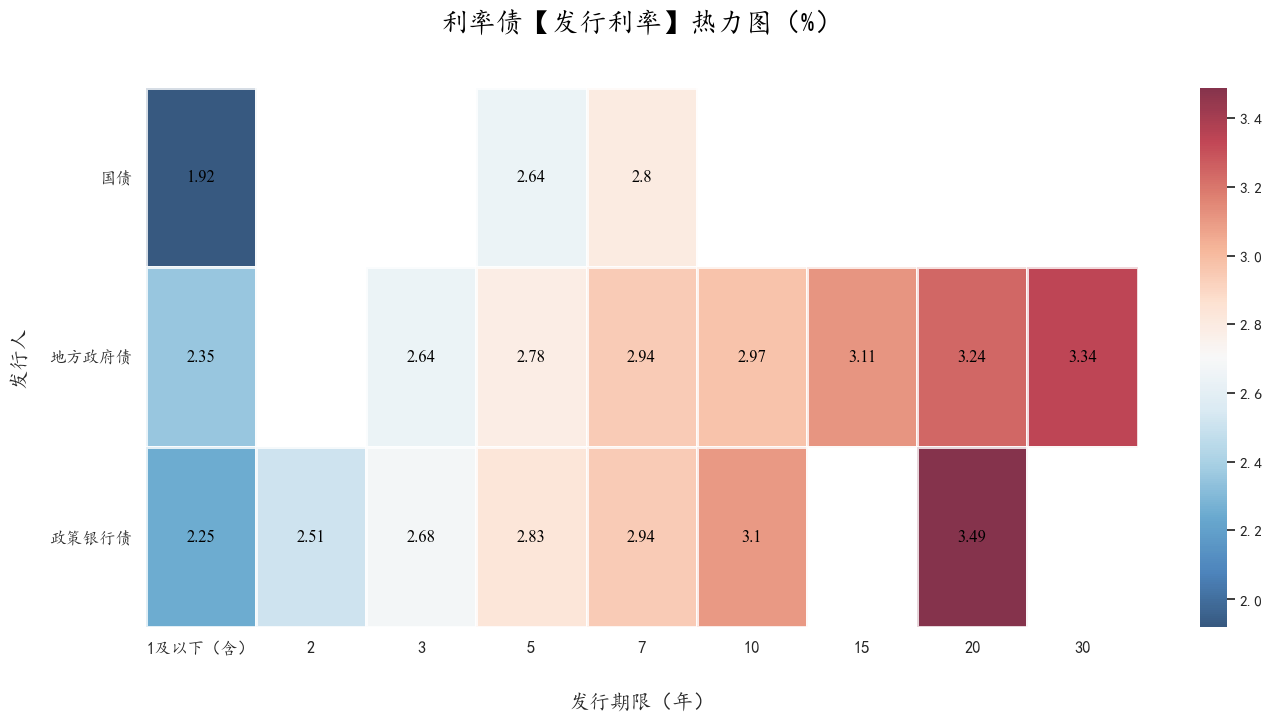

In [18]:
sns.set(font='KaiTi',style='white') #此行为正常显示中文：这里选择为楷体

plt.figure(figsize=(16,7))
# sns.set_context({"figure.figsize":(16,7)})
# sns.set_style('white') #有darkgrid（灰色背景+白网格）、whitegrid（白色背景+黑网格）、dark（仅灰色背景）、white（仅白色背景）
#                       #、ticks（坐标轴带刻度）5种预设的主题

sns.heatmap(policy_bond_data_IR_forplot, annot=True, fmt='g',annot_kws={"family":"Times New Roman","size": 12,'color':'black'},
            cmap="RdBu_r", cbar=True,cbar_kws={'orientation': 'vertical'},mask=False,linewidth=.8,linecolor='white',alpha=0.8,
            square=False)
#【好看的cmp】：后面加"_r"即代表色带相反——Greens Oranges OrRd summer summer_r vlag Wistia Blues RdBu_r Reds RdYlGn_r GnBu pink_r

# annot: 默认为False，为True的话，会在格子上显示数字
# annot_kws={"family":"Times New Roman","size": 12,'color':'black'} 修改方格内字体大小、颜色等
# mask可以设置条件判断，如：mask=(CD_IR<=0)
# square : 为‘True’时，整个网格为一个正方形
# cbar=True——显示右方颜色条

plt.title('利率债【发行利率】热力图（%）', fontsize = 20,color='black',fontweight='bold',
          bbox=dict(ec='w',fc ='white'), #facecolor(简写fc)背景颜色, edgecolor(简写ec)边框线条颜色                                                   
          fontstyle='normal',family='KaiTi',pad =40  # pad为调整标题与图片的距离
         )
plt.xlabel('发行期限（年）',family='KaiTi', fontsize = 15, fontweight='bold', labelpad=25) 
plt.ylabel('发行人',family='KaiTi',fontweight='bold',fontsize = 15, labelpad=15, rotation=90)

# #调整y轴【刻度】显示
plt.xticks(fontsize=12,fontproperties= 'KaiTi', rotation=0)
plt.yticks(fontsize=13,fontproperties = 'KaiTi',horizontalalignment='right',rotation=0)

#horizontalalignment='left',multialignment='left',
# horizontalalignment，控制文本的 x 位置参数，对齐左侧、中心或右侧:'center', 'right', 'left'
# verticalalignment 控制文本的 y 位置参数，对齐底部、中心或顶部:'top', 'bottom', 'center', 'baseline', 'center_baseline'
# multialignment，仅用于换行符分隔的字符串，控制不同的行是左对齐、居中还是右对齐。

plt.show()

<br/>

<center> <font face="songti",font size="6">【二级市场情况】

<br/>

In [19]:
#往前多少day——这里设置为90天，是为了画图好看，不然期限太短了，画出来的图太难看
beginTime = "-180D"

<br/>

<center> <font face="songti",font size="6">1.【国债】

In [20]:
#获取data

guozhai_list = ["M1001102","M1001104","M1001106","M1001108","M1001110","M1001113"]
guozhai_data =(
             w.wsd(codes=guozhai_list, fields="close", beginTime=beginTime, endTime=datetime.date.today(),usedf=True)
             )
guozhai_data = guozhai_data[1] #奇怪的很，不加[1]就是一个只有2个元素的tuple，第一个元素是一个"0"，所以取第二个元素，是一整个dataframe
#修改列名”
guozhai_data.rename(columns={'M1001102':'中债国债即期收益率：1年', 
                             'M1001104':'中债国债即期收益率：3年',
                             'M1001106':'中债国债即期收益率：5年',
                             'M1001108':'中债国债即期收益率：7年',
                             'M1001110':'中债国债即期收益率：10年',
                             'M1001113':'中债国债即期收益率：30年',
                            },inplace=True)  #修改列名”
#插入位置在左边一列“Date”
guozhai_data.insert(0, 'Date', guozhai_data.index)
#再次在最左边插入一列：按照“Date”排序的【序列】
guozhai_data.index = range(len(guozhai_data))
guozhai_data.insert(0, 'Order', guozhai_data.index)

guozhai_data.tail(7)

,Order,Date,中债国债即期收益率：1年,中债国债即期收益率：3年,中债国债即期收益率：5年,中债国债即期收益率：7年,中债国债即期收益率：10年,中债国债即期收益率：30年
116,116,2023-03-16,2.2365,2.5279,2.6936,2.8522,2.8934,3.3960
117,117,2023-03-17,2.2365,2.5282,2.6964,2.8478,2.8993,3.3756
118,118,2023-03-20,2.2217,2.5070,2.6670,2.8416,2.8899,3.3598
119,119,2023-03-21,2.2365,2.5199,2.6900,2.8430,2.9004,3.3608
120,120,2023-03-22,2.2600,2.5253,2.6982,2.8531,2.8962,3.3621
121,121,2023-03-23,2.2551,2.5254,2.7043,2.8637,2.9039,3.3750
122,122,2023-03-24,2.2798,2.5425,2.7168,2.8734,2.9053,3.3824


In [21]:
#上面多加了2列（列“Date”和“Order”），所以下面都要做相应的处理，统一用参数num_col表达
num_col = 2

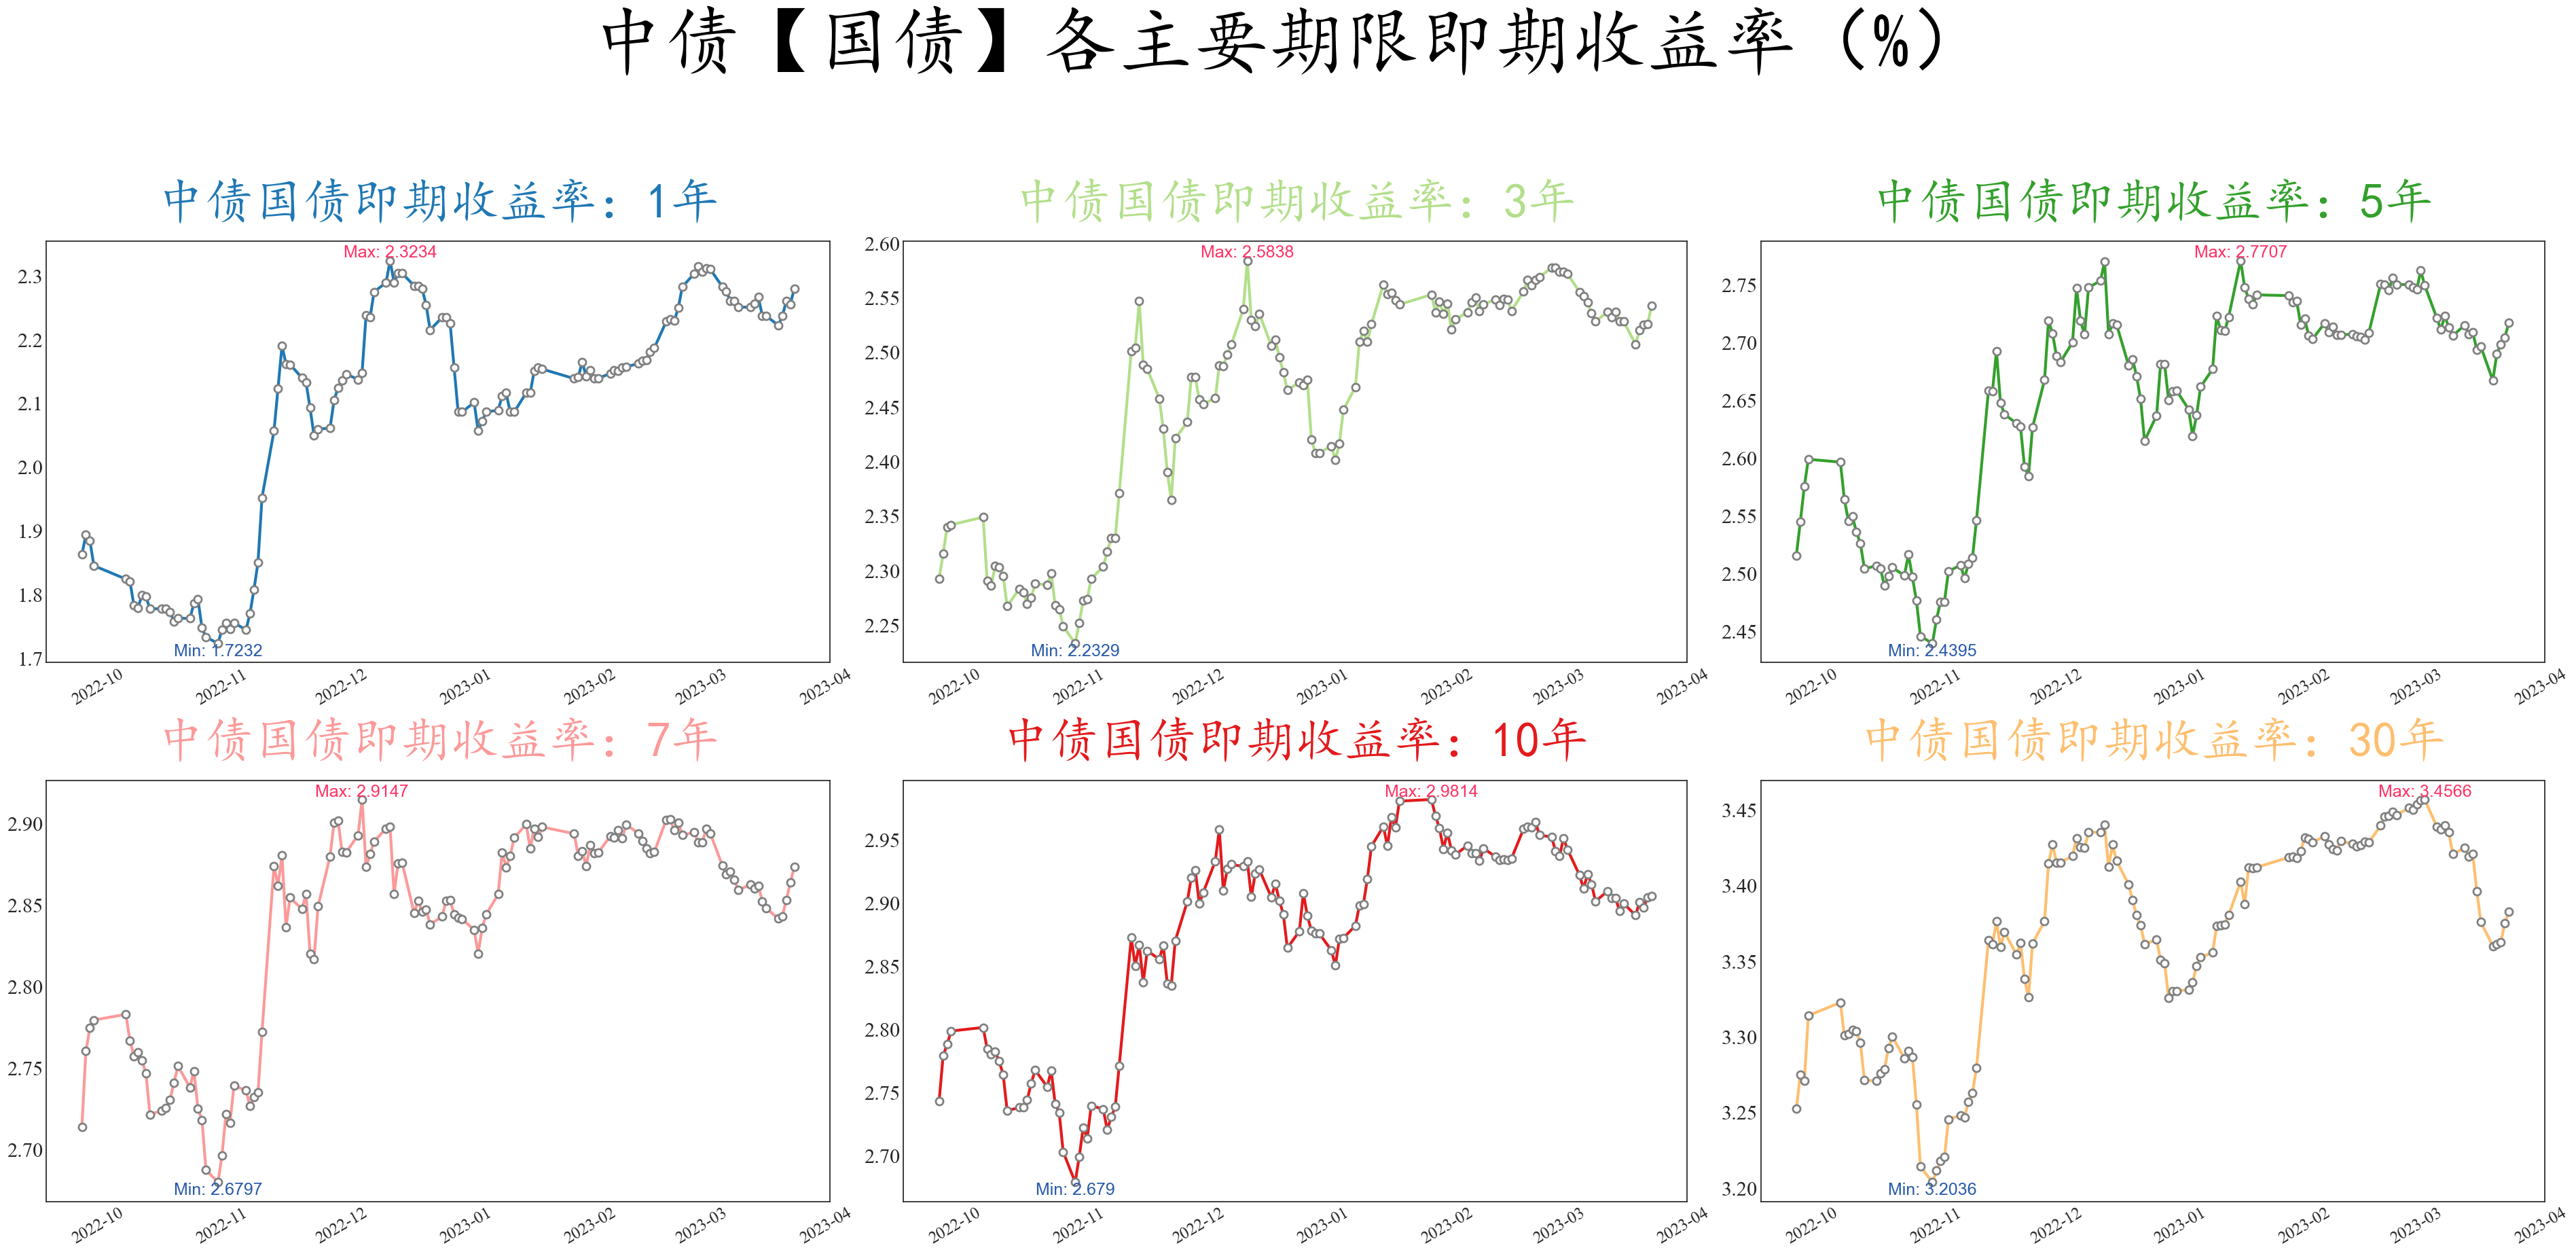

In [22]:
# 为提高【复用性】——采用“input_line_V1”作为画图的input，每次调用不同的数据赋值即可
input_line_V1 = guozhai_data



#【版本1】

plt.style.use('seaborn-white')   #效果不错的有：seaborn-white、seaborn-whitegrid、seaborn-ticks
 
# create a color palette
palette = plt.get_cmap('Paired')
# 【好看的cmp】：后面加"_r"即代表色带相反：Paired tab10 tab20

plt.figure(figsize=(38,16))  #这里代表是一整张画布的大小

# multiple line plot
num = 0

#每执行一次循环，则画一个子图
for column in range(input_line_V1.shape[1] - num_col):  #即range(0, 6),“- num_col”是因为上面多添加了2列
    num += 1    #这里最终num等于6
    
    # Find the right spot on the plot
    plt.subplot(2,3,num) #subplot(nrows, ncols, plot_number)，子图的行数为3、列数为3，按照从左到右，从上到下的顺序对每个子图进行编号

    #调整各子图间距，这里只调整上下间距
    plt.tight_layout(pad=0.8)   #h_pad=5.0,w_pad=5.0)  
    
    # Plot the lineplot（折线图）——调图片格式主要在这里
    plt.plot(input_line_V1.Date, input_line_V1.iloc[:,column+num_col], marker='o', markersize=8,   #marker及其一系列——标记风格
            #老代码：guozhai_data['Order'], guozhai_data.iloc[:,column+num_col], marker='o', markersize=10,#marker及其一系列——标记风格
             
             markerfacecolor="white",markeredgewidth=2,markeredgecolor="grey",
             color=palette(num), linewidth=3, label=column)  
   # plt.plot(x, y, format_string, **kwargs)  其中：x—X轴数据，列表或数组，y—Y轴数据，列表或数组

    #设置各子图x、y轴名词与字体大小
    #plt.xlabel('Date', fontproperties = 'Times New Roman',fontsize=22)
    #plt.ylabel('Rate', fontproperties = 'Times New Roman',fontsize=22)
    
    #设置各子图x、y轴刻度与字体大小
    plt.xticks(rotation=30,fontproperties = 'Times New Roman', size = 18)
    plt.yticks(fontproperties = 'Times New Roman', size = 22)
    
    
    # Same limits for every chart——调整每个子图的X与Y轴刻度的精细度
    plt.xlim(input_line_V1['Date'][0],input_line_V1['Date'].iloc[-1]) #使用时间来度量x轴
    
    plt.ylim(input_line_V1.iloc[:,num_col:].values.min()*0.95,input_line_V1.iloc[:,num_col:].values.max()*1.05) 
    #*0.95和1.05是为了稍微放大区间，为了好看
    plt.autoscale(enable=True, axis='both', tight=None) #模块控制坐标轴范围是否自动缩放的函数，开了以后非常好看

    
    #显示最大、最小值——代码完全来自Chatgpt
    
    #获取最值的索引
    max_index = input_line_V1.iloc[:,column+num_col].idxmax()
    min_index = input_line_V1.iloc[:,column+num_col].idxmin()
    
    
    #在对应点处显示最值的具体数值
    plt.text(input_line_V1.Date[max_index], input_line_V1.iloc[:,column+num_col][max_index], 
         'Max: ' + str(input_line_V1.iloc[:,column+num_col][max_index]), 
         fontsize=18, color='#FF3366', ha='center', va='bottom')
    plt.text(input_line_V1.Date[min_index], input_line_V1.iloc[:,column+num_col][min_index], 
         'Min: ' + str(input_line_V1.iloc[:,column+num_col][min_index]), 
         fontsize=18, color='#2a5caa', ha='center', va='top')
    
    #下面这段代码是有箭头指示的，没必要了
    
    #     plt.annotate('Max', xy=(guozhai_data.Date[max_index], guozhai_data.iloc[:,column+num_col][max_index]),
    #              xytext=(guozhai_data.Date[max_index]+pd.DateOffset(days=10), guozhai_data.iloc[:,column+num_col][max_index]+0.1),
    #              arrowprops=dict(facecolor='red', edgecolor='red', alpha=0.5), fontsize=12)

    #     plt.annotate('Min', xy=(guozhai_data.Date[min_index], guozhai_data.iloc[:,column+num_col][min_index]),
    #              xytext=(guozhai_data.Date[min_index]+pd.DateOffset(days=10), guozhai_data.iloc[:,column+num_col][min_index]-0.1),
    #              arrowprops=dict(facecolor='blue', edgecolor='blue', alpha=0.5), fontsize=12)

   
    # Add title
    plt.title(input_line_V1.columns.values[column + num_col],fontproperties = 'kaiti', loc='center',
              fontsize=52, fontweight=15, color=palette(num) ,pad=25)
    #columns.values为取列的名字
    
    
# general title
plt.suptitle("中债【国债】各主要期限即期收益率（%）", fontproperties = 'kaiti',
             fontsize=80, fontweight=5, color='black', style='normal', y=1.15) #y=1.05为标题与下图距离
                                                                                                         
# Show the graph
plt.show()


<br/>

<center> <font face="songti",font size="6">2.【政策性金融债】

<br/>

<center> <font face="songti",font size="6">2.1【国开债】

In [23]:
#往前多少day——这里设置为90天，是为了画图好看，不然期限太短了，画出来的图太难看
beginTime_guokai = "-360D"

In [24]:
#获取data

zhengjinzhai_list = ["M1004281","M1004283","M1004285","M1004287","M1004289","M1004292",
#                      "M1001128","M1001130","M1001132","M1001134","M1001136"
                     
                    ]


zhengjinzhai_data =(
             w.wsd(codes=zhengjinzhai_list, fields="close", beginTime=beginTime_guokai, endTime=datetime.date.today(),usedf=True)
             )
zhengjinzhai_data = zhengjinzhai_data[1] #一个只有2个元素的tuple，第一个元素是一个"0"，所以取第二个元素，是一整个dataframe
#修改列名”
zhengjinzhai_data.rename(columns={'M1004281':'中债国开债即期收益率：1年', 
                                  'M1004283':'中债国开债即期收益率：3年',
                                  'M1004285':'中债国开债即期收益率：5年',
                                  'M1004287':'中债国开债即期收益率：7年',
                                  'M1004289':'中债国开债即期收益率：10年',
                                  'M1004292':'中债国开债即期收益率：30年',
                                  
#                                   'M1001128':'中债进出口行债即期收益率：1年',
#                                   'M1001130':'中债进出口行债即期收益率：3年',
#                                   'M1001132':'中债进出口行债即期收益率：5年',
#                                   'M1001134':'中债进出口行债即期收益率：7年',
#                                   'M1001136':'中债进出口行债即期收益率：10年',
                                  },inplace=True)  #修改列名”
#插入位置在左边一列“Date”
zhengjinzhai_data.insert(0, 'Date', zhengjinzhai_data.index)
#再次在最左边插入一列：按照“Date”排序的【序列】
zhengjinzhai_data.index = range(len(zhengjinzhai_data))
zhengjinzhai_data.insert(0, 'Order', zhengjinzhai_data.index)

zhengjinzhai_data.tail(7)

,Order,Date,中债国开债即期收益率：1年,中债国开债即期收益率：3年,中债国开债即期收益率：5年,中债国开债即期收益率：7年,中债国开债即期收益率：10年,中债国开债即期收益率：30年
240,240,2023-03-16,2.521,2.7341,2.8537,3.0507,3.0296,3.3964
241,241,2023-03-17,2.496,2.7201,2.8578,3.0457,3.0312,3.3843
242,242,2023-03-20,2.466,2.6815,2.8094,3.0320,3.0116,3.3683
243,243,2023-03-21,2.479,2.7163,2.8359,3.0303,3.0187,3.3746
244,244,2023-03-22,2.474,2.7117,2.8301,3.0364,3.0193,3.3825
245,245,2023-03-23,2.459,2.7119,2.8436,3.0319,3.0320,3.3794
246,246,2023-03-24,2.458,2.7283,2.8580,3.0408,3.0377,3.3856


In [25]:
#上面多加了2列，所以下面都要做相应的处理，统一用参数num_col表达
num_col = 2

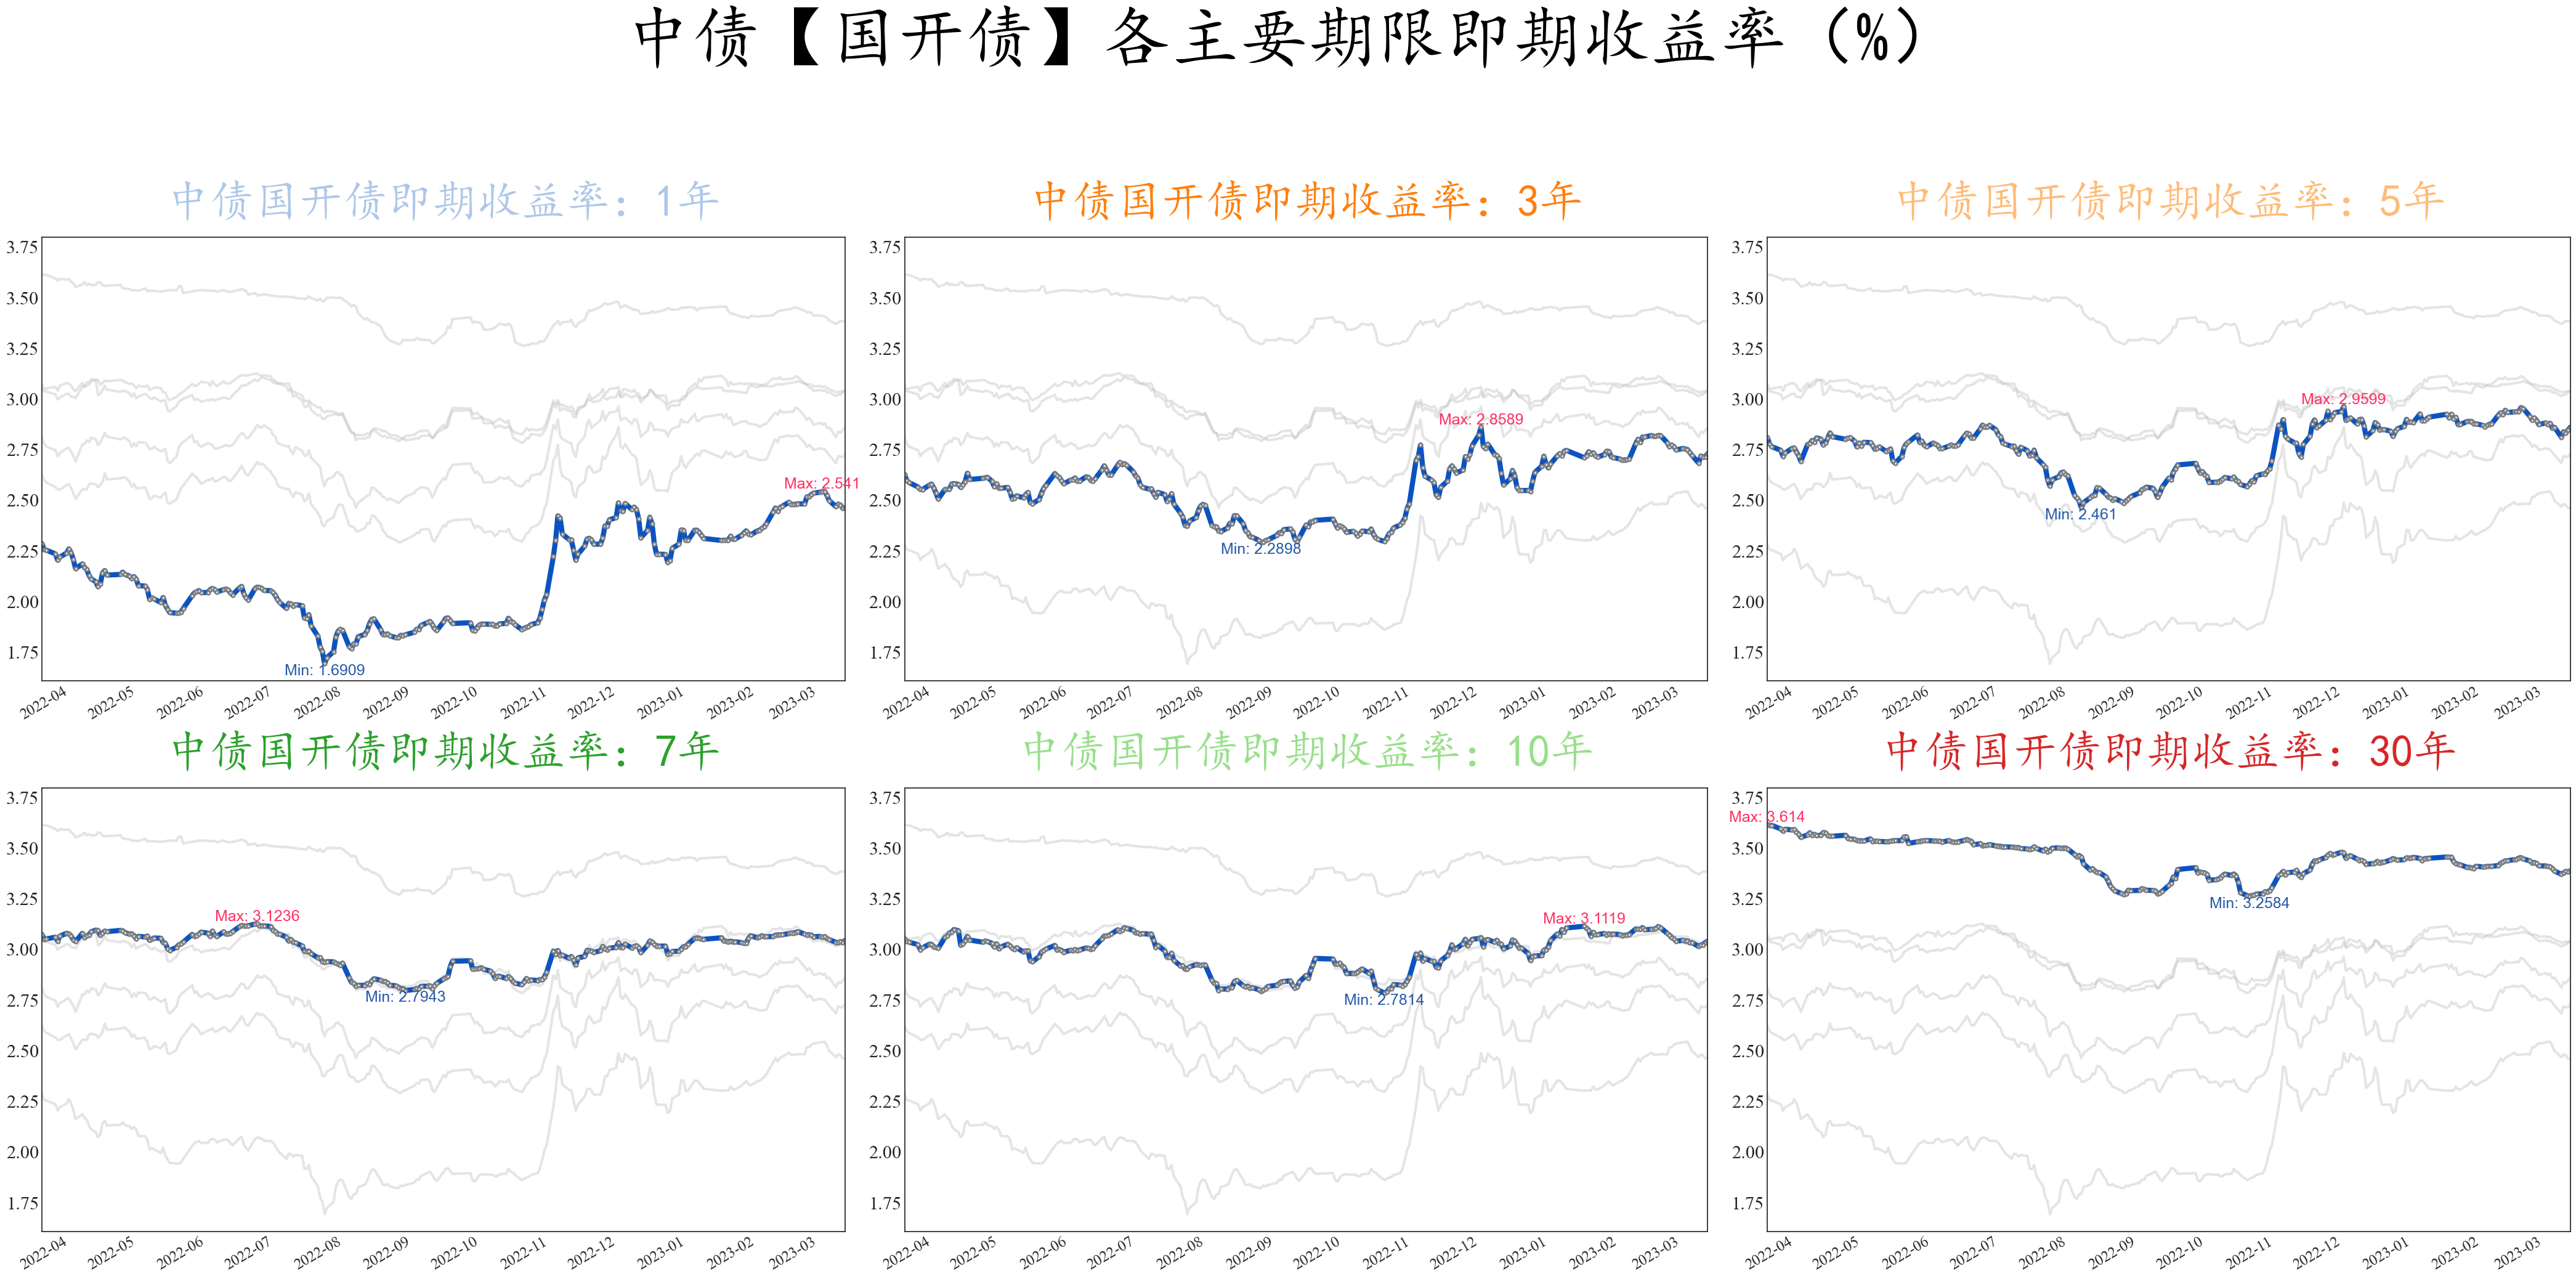

In [26]:
# 为提高【复用性】——采用“input_line_V2”作为画图的input，每次调用不同的数据赋值即可
input_line_V2 = zhengjinzhai_data



#【版本2】

plt.style.use('seaborn-white')   #效果不错的有：seaborn-white、seaborn-whitegrid、seaborn-ticks
 
# create a color palette
palette = plt.get_cmap('tab20')
# 【好看的cmp】：后面加"_r"即代表色带相反：Paired tab10 tab20

plt.figure(figsize=(42,18))  #这里代表是一整张画布的大小

# multiple line plot
num = 0

#每执行一次循环，则画一个子图
for column in range(input_line_V2.shape[1] - num_col):  #即range(0, 6),“- num_col”是因为上面多添加了2列
    num += 1    #这里最终num等于6
    
    # Find the right spot on the plot
    plt.subplot(2,3,num) #subplot(nrows, ncols, plot_number)，子图的行数为3、列数为3，按照从左到右，从上到下的顺序对每个子图进行编号

    #调整各子图间距，这里只调整上下间距
    plt.tight_layout(pad=0.8)   #h_pad=5.0,w_pad=5.0)  
    
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~较版本1唯一新增代码：画灰色线部分~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~       
    
    # plot every group, but discrete
    for v in range(input_line_V2.shape[1] - num_col):
        plt.plot(input_line_V2.Date, input_line_V2.iloc[:,v + num_col], marker=',', color="#BFBFBF", linewidth=3, alpha=0.4)
                                                                                 #一开始是"grey"，不如这个好看
            
 #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~较版本1唯一新增代码：画灰色线部分~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~     
    
  
    
    # Plot the lineplot（折线图）——调图片格式主要在这里
    plt.plot(input_line_V2.Date, input_line_V2.iloc[:,column + num_col], marker='.', markersize=8,   #marker及其一系列——标记风格               
             markerfacecolor="white",markeredgewidth=2,markeredgecolor="grey",
             color="#0b53c1", linewidth=6, label=column)  
             #color=palette(num)——循环不同颜色
    
    # plt.plot(x, y, format_string, **kwargs)  其中：x—X轴数据，列表或数组，y—Y轴数据，列表或数组

    
    #设置各子图x、y轴名词与字体大小
    #plt.xlabel('Date', fontproperties = 'Times New Roman',fontsize=22)
    #plt.ylabel('Rate', fontproperties = 'Times New Roman',fontsize=22)
    
    #设置各子图x、y轴刻度与字体大小
    plt.xticks(rotation=30,fontproperties = 'Times New Roman', size = 18)
    plt.yticks(fontproperties = 'Times New Roman', size = 22)
    
    
    # Same limits for every chart——调整每个子图的X与Y轴刻度的精细度
    plt.xlim(input_line_V2['Date'][0],input_line_V2['Date'].iloc[-1]) #使用时间来度量x轴
    
    plt.ylim(input_line_V2.iloc[:,num_col:].values.min()*0.95,input_line_V2.iloc[:,num_col:].values.max()*1.05) 
    #*0.95和1.05是为了稍微放大区间，为了好看
    plt.autoscale(enable=True, axis='1', tight=None) #模块控制坐标轴范围是否自动缩放的函数，开了以后非常好看

    
    #显示最大、最小值——代码完全来自Chatgpt
    
    #获取最值的索引
    max_index = input_line_V2.iloc[:,column+num_col].idxmax()
    min_index = input_line_V2.iloc[:,column+num_col].idxmin()
    
    
    #在对应点处显示最值的具体数值
    plt.text(input_line_V2.Date[max_index], input_line_V2.iloc[:,column+num_col][max_index], 
         'Max: ' + str(input_line_V2.iloc[:,column+num_col][max_index]), 
         fontsize=18, color='#FF3366', ha='center', va='bottom')
    plt.text(input_line_V2.Date[min_index], input_line_V2.iloc[:,column+num_col][min_index], 
         'Min: ' + str(input_line_V2.iloc[:,column+num_col][min_index]), 
         fontsize=18, color='#2a5caa', ha='center', va='top')
   

    # Add title
    plt.title(input_line_V2.columns.values[column + num_col],fontproperties = 'kaiti', loc='center',
              fontsize=52, fontweight=15, color=palette(num) ,pad=25)
    #columns.values为取列的名字
    
    
# general title
plt.suptitle("中债【国开债】各主要期限即期收益率（%）", fontproperties = 'kaiti',
             fontsize=80, fontweight=5, color='black', style='normal', y=1.15) #y=1.05为标题与下图距离
                                                                                                         
# Show the graph
plt.show()